#### 1. Load Data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset.csv')

# Check for missing values in the dataset and summarize them
missing_values = df.isnull().sum()

# Count the number of samples with missing values
samples_with_missing_values = df[df.isnull().any(axis=1)].shape[0]

print(f"Number of samples with missing values in the dataset: {samples_with_missing_values}")


Number of samples with missing values in the dataset: 44


In [2]:
# Delete samples with missing values
df_cleaned = df.dropna()

#### 2. Using random stratified sampling, the data set was divided into a training set and a test set on a 4:1 basis

In [3]:
from sklearn.model_selection import train_test_split

SEED = 42

df_cleaned = df_cleaned.drop('ID', axis=1)

# Random stratified sampling divides the data set into training set and test set
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, stratify=df_cleaned['Result'], random_state=SEED)

#### 3. normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Define continuous variables and categorical variables
continuous_columns = ['Age','Weight','EGFR']  # continuous variables
categorical_columns = [feature for feature in df.columns if feature not in ['Result'] and feature not in continuous_columns]

scaler = MinMaxScaler()
scaler.fit(train_df[continuous_columns])

min_values = train_df[continuous_columns].min()
max_values = train_df[continuous_columns].max()

# Only the continuous variables need to be normalized
train_df[continuous_columns] = scaler.fit_transform(train_df[continuous_columns])
test_df[continuous_columns] = scaler.transform(test_df[continuous_columns])

In [6]:
'''Customize a MinMaxScaler normalization to take the maximum and minimum values of the training set as the standard, 
   which is convenient for the final application.
'''

def min_max_scaler(df, min_values, max_values):
    scaled_df = (df - min_values) / (max_values - min_values)
    scaled_df = scaled_df.clip(0, 1)  # Ensure all values are within [0, 1]
    return scaled_df

# Example
#scaled_test_df = min_max_scaler(test_df[continuous_columns], min_values, max_values)

#### 4. Model screening, LR, RF, SVM, GBDT training process using the default parameters

Logistic Regression - Mean AUC: 0.7158730158730159, Mean Recall: 0.6408602150537633, Mean Accuracy: 0.6678256602879719
Random Forest - Mean AUC: 0.6864503328213005, Mean Recall: 0.5763440860215053, Mean Accuracy: 0.6342571443073955
GradientBoostingClassifier - Mean AUC: 0.6451378221539512, Mean Recall: 0.6086021505376343, Mean Accuracy: 0.6057983520295078
XGBClassifier - Mean AUC: 0.6627816180235535, Mean Recall: 0.6412186379928315, Mean Accuracy: 0.6058406510667816


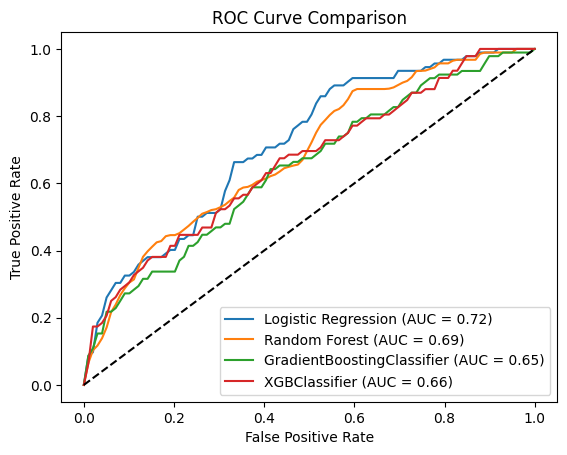

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

from imblearn.under_sampling import RandomUnderSampler

original_X_train = train_df.drop('Result', axis=1)
original_y_train = train_df['Result']

# Initializes the classifier
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=SEED, max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=SEED),
    'XGBClassifier': XGBClassifier(random_state=SEED)
}

# Because the training set sample is small, use 3-fold cross validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Store the average ROC curve for each model
mean_tprs = {}
mean_fpr = np.linspace(0, 1, 100)

# Store the average AUC value for each model
mean_aucs = {}

# Start cross-validation
for name, clf in classifiers.items():
    tprs = []
    auc_scores = []
    recall_scores = []
    accuracy_scores = []

    for train_index, valid_index in skf.split(original_X_train, original_y_train):
        X_train, X_valid = original_X_train.iloc[train_index], original_X_train.iloc[valid_index]
        y_train, y_valid = original_y_train.iloc[train_index], original_y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        # Calculate the AUC
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
        # Calculate the Recall
        recall = recall_score(y_valid, clf.predict(X_valid))
        recall_scores.append(recall)
        
        # Calculate the Accuracy
        accuracy = accuracy_score(y_valid, clf.predict(X_valid))
        accuracy_scores.append(accuracy)
        
        # plot the ROC curve
        fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    # Store the average ROC curve and average AUC values for each model
    mean_tprs[name] = np.mean(tprs, axis=0)
    mean_aucs[name] = np.mean(auc_scores)
    print(f"{name} - Mean AUC: {mean_aucs[name]}, Mean Recall: {np.mean(recall_scores)}, Mean Accuracy: {np.mean(accuracy_scores)}")

# plot the ROC curves
plt.figure()
for name, mean_tpr in mean_tprs.items():
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_aucs[name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random probability line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
#plt.savefig('cross-validation.pdf', format='pdf')
plt.show()


#### 5. Feature Selection(RFE)

Logistic Regression best_feature_set: ['CAT', 'Age', 'EGFR', 'ALB', 'NLR', 'PS', 'CA', 'COPD', 'BE', 'CVD', 'HF', 'PIPD']


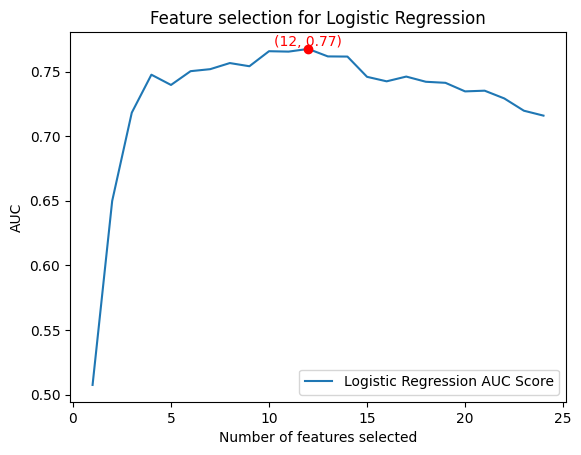

Random Forest best_feature_set: ['CAT', 'Age', 'Weight', 'EGFR', 'Sex', 'BUN', 'ALB', 'Temp', 'WBC', 'CRP', 'NLR', 'RF', 'PS', 'RH', 'DM', 'CA', 'COPD', 'BE', 'ILD', 'CVD', 'HF', 'OPTH', 'PIPD']


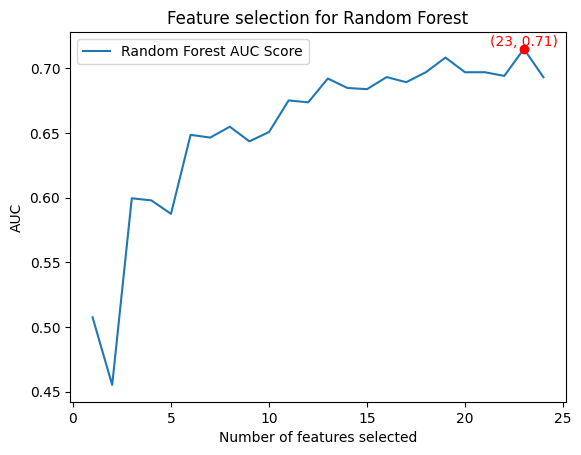

GradientBoostingClassifier best_feature_set: ['CAT', 'Age', 'Weight', 'EGFR', 'ALB', 'NLR', 'RF', 'CA', 'COPD', 'CVD', 'HF', 'OPTH', 'PIPD']


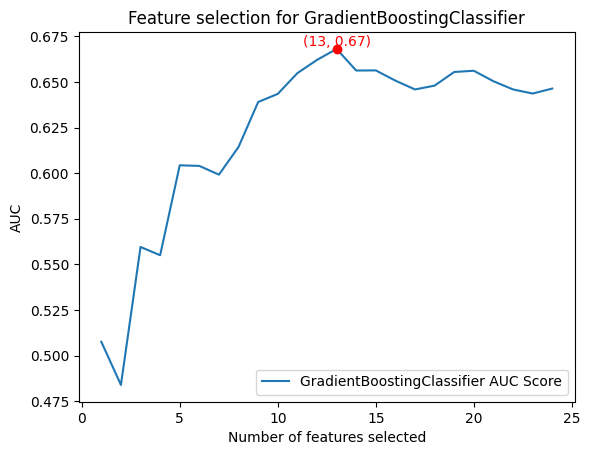

XGBClassifier best_feature_set: ['CAT', 'ALB', 'COPD']


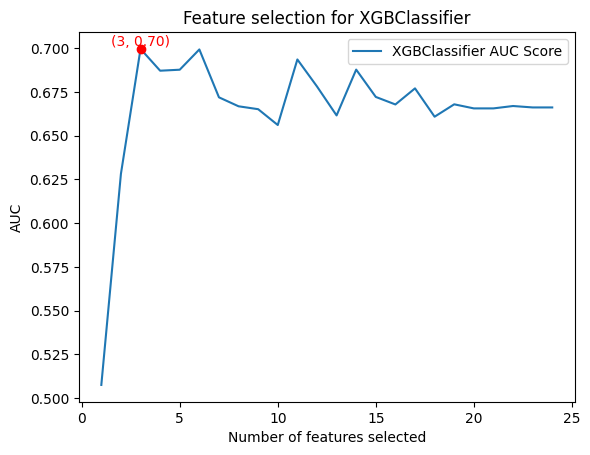

In [11]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

# Initialize the classifier
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=SEED, max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=SEED),
    'XGBClassifier': XGBClassifier(random_state=SEED)
}

rfe_scores = {}
best_features = {}

for name, clf in classifiers.items():
    # Stores roc_auc under the current feature subset
    scores = []
    
    
    # First, the AUC is computed using only the 'CAT' feature and stored in scores
    X_train_cd = original_X_train[['CAT']]
    fold_auc_list_cd = []
    for train_index, valid_index in skf.split(X_train_cd, original_y_train):
        X_train, X_valid = X_train_cd.iloc[train_index], X_train_cd.iloc[valid_index]
        y_train, y_valid = original_y_train.iloc[train_index], original_y_train.iloc[valid_index]

        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]

        fold_auc = roc_auc_score(y_valid, y_pred_proba)
        fold_auc_list_cd.append(fold_auc)

    # Store AUC with only 'CAT' features to scores
    scores.append(np.mean(fold_auc_list_cd))
    
    # Fixed 'CAT''
    X_train_rfe = original_X_train.drop('CAT', axis=1)
    # RFE is performed feature by feature
    for i in range(1, len(X_train_rfe.columns) + 1):
        rfe = RFE(estimator=clf, n_features_to_select=i)
        rfe.fit(X_train_rfe, original_y_train)
        
        # Select the feature currently selected by RFE
        selected_features = X_train_rfe.columns[rfe.support_].tolist()
        selected_features.insert(0, 'CAT')
        
        # Store every fold of AUC
        fold_auc_list = []
        
        for train_index, valid_index in skf.split(original_X_train[selected_features], original_y_train):
            X_train, X_valid = original_X_train[selected_features].iloc[train_index], original_X_train[selected_features].iloc[valid_index]
            y_train, y_valid = original_y_train.iloc[train_index], original_y_train.iloc[valid_index]
        
            rus = RandomUnderSampler(random_state=SEED)
            X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
        
            clf.fit(X_train_resampled, y_train_resampled)
            y_pred_proba = clf.predict_proba(X_valid)[:, 1]
            
            fold_auc = roc_auc_score(y_valid, y_pred_proba)
            fold_auc_list.append(fold_auc)
        
        # Stores the average roc_auc for cross-validation under the current feature subset
        scores.append(np.mean(fold_auc_list))
    
    # Stores roc_auc for the current model under the current feature subset
    rfe_scores[name] = scores
    
    # Find the feature subset with the highest score
    best_index = np.argmax(scores)
    rfe = RFE(estimator=clf, n_features_to_select=best_index)
    rfe.fit(X_train_rfe, original_y_train)
    # Select the feature currently selected by RFE
    selected_features = X_train_rfe.columns[rfe.support_].tolist()
    selected_features.insert(0, 'CAT')
    best_feature_set = selected_features
    print(f'{name} best_feature_set: {best_feature_set}')
    
    # Stores the highest feature subset of the current model AUC
    best_features[name] = best_feature_set
    
    # Visualization
    plt.figure()
    plt.title(f'Feature selection for {name}')
    plt.xlabel('Number of features selected')
    plt.ylabel('AUC')
    
    x_axis = np.arange(1, len(original_X_train.columns) + 1)  # The X-axis represents a total of 24 features
    
    # Draw a score curve
    plt.plot(x_axis, scores, label=f'{name} AUC Score')
    
    # Mark the highest point
    plt.scatter(best_index+1, scores[best_index], color='red', zorder=5)
    plt.text(best_index+1, scores[best_index],
            f'({best_index+1}, {scores[best_index]:.2f})',
             color='red', ha='center',va='bottom')

    plt.legend(loc='best')
    #plt.savefig(f'{name}_feature_selection.pdf', format='pdf')
    plt.show()

In [12]:
# Outputs the optimal subset of features for each model
for name, features in best_features.items():
    print(f"Model: {name}, Best features: {features}")

Model: Logistic Regression, Best features: ['CAT', 'Age', 'EGFR', 'ALB', 'NLR', 'PS', 'CA', 'COPD', 'BE', 'CVD', 'HF', 'PIPD']
Model: Random Forest, Best features: ['CAT', 'Age', 'Weight', 'EGFR', 'Sex', 'BUN', 'ALB', 'Temp', 'WBC', 'CRP', 'NLR', 'RF', 'PS', 'RH', 'DM', 'CA', 'COPD', 'BE', 'ILD', 'CVD', 'HF', 'OPTH', 'PIPD']
Model: GradientBoostingClassifier, Best features: ['CAT', 'Age', 'Weight', 'EGFR', 'ALB', 'NLR', 'RF', 'CA', 'COPD', 'CVD', 'HF', 'OPTH', 'PIPD']
Model: XGBClassifier, Best features: ['CAT', 'ALB', 'COPD']


In [13]:
rfe_features = {
    'Logistic Regression': ['CAT', 'Age', 'EGFR', 'ALB', 'NLR', 'PS', 'CA', 'COPD', 'BE', 'CVD', 'HF', 'PIPD'],
    'Random Forest': ['CAT', 'Age', 'Weight', 'EGFR', 'Sex', 'BUN', 'ALB', 'Temp', 'WBC', 'CRP', 'NLR', 'RF', 'PS', 'RH', 'DM', 'CA', 'COPD', 'BE', 'ILD', 'CVD', 'HF', 'OPTH', 'PIPD'],
    'GradientBoostingClassifier': ['CAT', 'Age', 'Weight', 'EGFR', 'ALB', 'NLR', 'RF', 'CA', 'COPD', 'CVD', 'HF', 'OPTH', 'PIPD'],
    'XGBClassifier': ['CAT', 'ALB', 'COPD']
}

#### 6. Retrain

Logistic Regression - Mean AUC: 0.7674880525686977, Mean Recall: 0.6967741935483872, Mean Accuracy: 0.6980694719388186
Random Forest - Mean AUC: 0.7148009472606246, Mean Recall: 0.6089605734767024, Mean Accuracy: 0.659425071485373
GradientBoostingClassifier - Mean AUC: 0.6681238265915685, Mean Recall: 0.6405017921146954, Mean Accuracy: 0.6208906485288395
XGBClassifier - Mean AUC: 0.6995498378562895, Mean Recall: 0.5422939068100359, Mean Accuracy: 0.6846352977006243


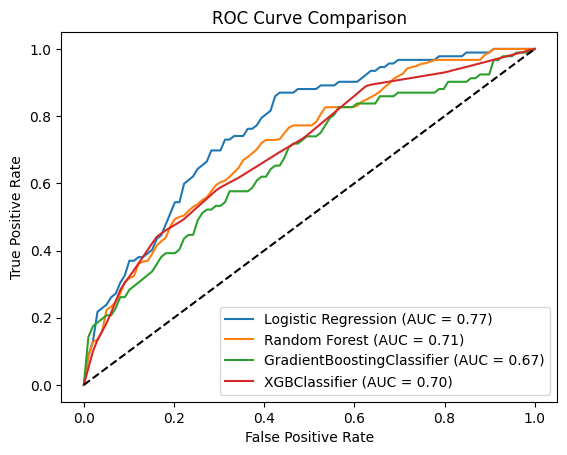

In [14]:
mean_tprs = {}
mean_fpr = np.linspace(0, 1, 100)

mean_aucs = {}


for name, clf in classifiers.items():  

    features = rfe_features[name]
    X_train_selected = original_X_train[features]
    
    tprs = []
    auc_scores = []
    recall_scores = []
    accuracy_scores = []

    for train_index, valid_index in skf.split(X_train_selected, original_y_train):
        X_train, X_valid = X_train_selected.iloc[train_index], X_train_selected.iloc[valid_index]
        y_train, y_valid = original_y_train.iloc[train_index], original_y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
        recall = recall_score(y_valid, clf.predict(X_valid))
        recall_scores.append(recall)
        
        accuracy = accuracy_score(y_valid, clf.predict(X_valid))
        accuracy_scores.append(accuracy)
        
        fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tprs[name] = np.mean(tprs, axis=0)
    mean_aucs[name] = np.mean(auc_scores)
    print(f"{name} - Mean AUC: {mean_aucs[name]}, Mean Recall: {np.mean(recall_scores)}, Mean Accuracy: {np.mean(accuracy_scores)}")

plt.figure()
for name, mean_tpr in mean_tprs.items():
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_aucs[name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
#plt.savefig('cross-validation.pdf', format='pdf')
plt.show()

#### 7. Hyperparameter Optimization

##### LR

In [15]:
import optuna
import warnings
warnings.filterwarnings('ignore')

def objective_lr(trial, X_train, y_train, features):
    param = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e+6), 
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none']),
        'solver': 'saga',
        'max_iter': 2000,
        'random_state': SEED
    }
    if param['penalty'] == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

    clf = LogisticRegression(**param)
    
    auc_scores = []
    
    for train_index, valid_index in skf.split(X_train[features], y_train):
        X_train_split, X_valid = X_train[features].iloc[train_index], X_train[features].iloc[valid_index]
        y_train_split, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train_split, y_train_split)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        # 计算AUC
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
    auc = np.mean(auc_scores)

    return auc

In [20]:
lr_features = ['CAT', 'Age', 'EGFR', 'ALB', 'NLR', 'PS', 'CA', 'COPD', 'BE', 'CVD', 'HF', 'PIPD']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_lr(trial, original_X_train, original_y_train, lr_features), n_trials=100)

print(f"Best Params: {study.best_params}, Best AUC: {study.best_value}")

[I 2024-02-01 10:25:06,676] A new study created in memory with name: no-name-e01b3097-4f85-411a-a83a-d4a4512eb178
[I 2024-02-01 10:25:06,701] Trial 0 finished with value: 0.5 and parameters: {'C': 0.002314004954567444, 'penalty': 'l1'}. Best is trial 0 with value: 0.5.
[I 2024-02-01 10:25:06,722] Trial 1 finished with value: 0.5 and parameters: {'C': 3.5727300861810793e-06, 'penalty': 'l1'}. Best is trial 0 with value: 0.5.
[I 2024-02-01 10:25:06,742] Trial 2 finished with value: 0.5 and parameters: {'C': 2.00575536860068e-06, 'penalty': 'l1'}. Best is trial 0 with value: 0.5.
[I 2024-02-01 10:25:06,773] Trial 3 finished with value: 0.7570297832394607 and parameters: {'C': 935.9981243606172, 'penalty': 'l2'}. Best is trial 3 with value: 0.7570297832394607.
[I 2024-02-01 10:25:06,795] Trial 4 finished with value: 0.5 and parameters: {'C': 0.0013695228457193973, 'penalty': 'elasticnet', 'l1_ratio': 0.1900753900707255}. Best is trial 3 with value: 0.7570297832394607.
[I 2024-02-01 10:25:0

[I 2024-02-01 10:25:08,012] Trial 44 finished with value: 0.7672405700631507 and parameters: {'C': 0.3873596906365842, 'penalty': 'l2'}. Best is trial 31 with value: 0.7679424816521591.
[I 2024-02-01 10:25:08,031] Trial 45 finished with value: 0.7598672981737499 and parameters: {'C': 0.028497045918497315, 'penalty': 'l2'}. Best is trial 31 with value: 0.7679424816521591.
[I 2024-02-01 10:25:08,079] Trial 46 finished with value: 0.7570297832394607 and parameters: {'C': 3.648009480660287, 'penalty': 'none'}. Best is trial 31 with value: 0.7679424816521591.
[I 2024-02-01 10:25:08,098] Trial 47 finished with value: 0.7659732889571599 and parameters: {'C': 0.2487756651617849, 'penalty': 'l2'}. Best is trial 31 with value: 0.7679424816521591.
[I 2024-02-01 10:25:08,131] Trial 48 finished with value: 0.7580218467315242 and parameters: {'C': 38.73541934326311, 'penalty': 'l2'}. Best is trial 31 with value: 0.7679424816521591.
[I 2024-02-01 10:25:08,166] Trial 49 finished with value: 0.75776796

[I 2024-02-01 10:25:09,283] Trial 88 finished with value: 0.7662293053422086 and parameters: {'C': 0.26305127304436515, 'penalty': 'l2'}. Best is trial 79 with value: 0.7682625021334699.
[I 2024-02-01 10:25:09,324] Trial 89 finished with value: 0.7570297832394607 and parameters: {'C': 0.5977725044975204, 'penalty': 'none'}. Best is trial 79 with value: 0.7682625021334699.
[I 2024-02-01 10:25:09,353] Trial 90 finished with value: 0.7625981396142687 and parameters: {'C': 2.494585269733278, 'penalty': 'l2'}. Best is trial 79 with value: 0.7682625021334699.
[I 2024-02-01 10:25:09,383] Trial 91 finished with value: 0.7677547363031234 and parameters: {'C': 0.8178076604403198, 'penalty': 'l2'}. Best is trial 79 with value: 0.7682625021334699.
[I 2024-02-01 10:25:09,408] Trial 92 finished with value: 0.7652692438982761 and parameters: {'C': 0.12149622035896022, 'penalty': 'l2'}. Best is trial 79 with value: 0.7682625021334699.
[I 2024-02-01 10:25:09,432] Trial 93 finished with value: 0.7665514

Best Params: {'C': 0.581732165256128, 'penalty': 'l2'}, Best loss: 0.7682625021334699


In [23]:
rus = RandomUnderSampler(random_state=SEED)

X_train_resampled, y_train_resampled = rus.fit_resample(original_X_train[lr_features], original_y_train)

In [24]:
# Get the best hyperparameters
best_params = study.best_params

# Add random state to optimal parameter
best_params['random_state'] = SEED

# Create a model instance with the best parameters
best_model = LogisticRegression(**best_params)

# Training model
best_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.581732165256128, random_state=42)

##### RF

In [27]:
def objective_rf(trial, X_train, y_train, features):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 2, 18),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 18),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 18),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state':SEED
    }

    clf = RandomForestClassifier(**param)
    
    auc_scores = []
    
    for train_index, valid_index in skf.split(X_train[features], y_train):
        X_train_split, X_valid = X_train[features].iloc[train_index], X_train[features].iloc[valid_index]
        y_train_split, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train_split, y_train_split)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
    auc = np.mean(auc_scores)

    return auc

In [28]:
rf_features = ['CAT', 'Age', 'Weight', 'EGFR', 'Sex', 'BUN', 'ALB', 'Temp', 'WBC', 'CRP', 'NLR', 'RF', 'PS', 'RH', 'DM', 'CA', 'COPD', 'BE', 'ILD', 'CVD', 'HF', 'OPTH', 'PIPD']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_rf(trial, original_X_train, original_y_train, rf_features), n_trials=100)

print(f"Best Params: {study.best_params}, Best AUC: {study.best_value}")

[I 2024-02-01 10:28:51,446] A new study created in memory with name: no-name-737b0747-aba0-4c99-a532-d33bea8c50fa
[I 2024-02-01 10:28:52,367] Trial 0 finished with value: 0.7105350742447517 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.7105350742447517.
[I 2024-02-01 10:28:53,975] Trial 1 finished with value: 0.711911162314388 and parameters: {'n_estimators': 456, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.711911162314388.
[I 2024-02-01 10:28:55,683] Trial 2 finished with value: 0.7057347670250896 and parameters: {'n_estimators': 544, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.711911162314388.
[I 2024-02-01 10:28:56,187] Trial 3 finished with value: 0.7146164021164022 and parameters: {'n_estimators': 197, 'max_depth': 18, 'min_s

[I 2024-02-01 10:29:30,975] Trial 32 finished with value: 0.7220344768731866 and parameters: {'n_estimators': 752, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:29:32,816] Trial 33 finished with value: 0.7216995221027479 and parameters: {'n_estimators': 747, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:29:34,694] Trial 34 finished with value: 0.7213837685611879 and parameters: {'n_estimators': 757, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:29:36,354] Trial 35 finished with value: 0.7165770609318997 and parameters: {'n_estimators': 657, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 23 with value: 0.7

[I 2024-02-01 10:30:29,426] Trial 65 finished with value: 0.7214435057176992 and parameters: {'n_estimators': 751, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:30:31,447] Trial 66 finished with value: 0.7218616658132788 and parameters: {'n_estimators': 798, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:30:33,294] Trial 67 finished with value: 0.7223608977641236 and parameters: {'n_estimators': 742, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:30:33,887] Trial 68 finished with value: 0.7214755077658302 and parameters: {'n_estimators': 228, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 23 with value: 0.72

[I 2024-02-01 10:31:28,065] Trial 98 finished with value: 0.7221198156682028 and parameters: {'n_estimators': 784, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.7265702338282983.
[I 2024-02-01 10:31:30,227] Trial 99 finished with value: 0.7176907322068612 and parameters: {'n_estimators': 722, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.7265702338282983.


Best Params: {'n_estimators': 102, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2'}, Best AUC: 0.7265702338282983


In [29]:
rus = RandomUnderSampler(random_state=SEED)

X_train_resampled, y_train_resampled = rus.fit_resample(original_X_train[rf_features], original_y_train)

In [30]:
best_params = study.best_params

best_params['random_state'] = SEED

best_model = RandomForestClassifier(**best_params)

best_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=14, max_features='log2', min_samples_leaf=12,
                       min_samples_split=13, n_estimators=102, random_state=42)

##### GBC

In [17]:
def objective_gbc(trial, X_train, y_train, features):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 18),
        'random_state':SEED
        }

    clf = GradientBoostingClassifier(**param)
    
    auc_scores = []
    
    for train_index, valid_index in skf.split(X_train[features], y_train):
        X_train_split, X_valid = X_train[features].iloc[train_index], X_train[features].iloc[valid_index]
        y_train_split, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train_split, y_train_split)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
    auc = np.mean(auc_scores)

    return auc

In [18]:
gbc_features = ['CAT', 'Age', 'Weight', 'EGFR', 'ALB', 'NLR', 'RF', 'CA', 'COPD', 'CVD', 'HF', 'OPTH', 'PIPD']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_gbc(trial, original_X_train, original_y_train, gbc_features), n_trials=100)

print(f"Best Params: {study.best_params}, Best AUC: {study.best_value}")

[I 2024-03-11 14:03:01,029] A new study created in memory with name: no-name-9f91440d-1b19-4a5d-bc77-593051ce557a
[I 2024-03-11 14:03:01,759] Trial 0 finished with value: 0.6779996586448199 and parameters: {'n_estimators': 671, 'learning_rate': 0.6360599486580871, 'max_depth': 6}. Best is trial 0 with value: 0.6779996586448199.
[I 2024-03-11 14:03:02,077] Trial 1 finished with value: 0.6371330431814304 and parameters: {'n_estimators': 178, 'learning_rate': 0.4135447980042865, 'max_depth': 9}. Best is trial 0 with value: 0.6779996586448199.
[I 2024-03-11 14:03:02,622] Trial 2 finished with value: 0.62942054958184 and parameters: {'n_estimators': 435, 'learning_rate': 0.3754125698903312, 'max_depth': 13}. Best is trial 0 with value: 0.6779996586448199.
[I 2024-03-11 14:03:03,144] Trial 3 finished with value: 0.690036695681857 and parameters: {'n_estimators': 496, 'learning_rate': 0.8925894878457086, 'max_depth': 8}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:03,82

[I 2024-03-11 14:03:25,156] Trial 38 finished with value: 0.5977449223416965 and parameters: {'n_estimators': 413, 'learning_rate': 0.6945840720606558, 'max_depth': 10}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:25,901] Trial 39 finished with value: 0.6737967229902714 and parameters: {'n_estimators': 693, 'learning_rate': 0.796626489002296, 'max_depth': 6}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:26,625] Trial 40 finished with value: 0.66376301416624 and parameters: {'n_estimators': 529, 'learning_rate': 0.39787832859675054, 'max_depth': 5}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:27,426] Trial 41 finished with value: 0.6737455197132617 and parameters: {'n_estimators': 670, 'learning_rate': 0.6183041869017131, 'max_depth': 7}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:28,200] Trial 42 finished with value: 0.666963218979348 and parameters: {'n_estimators': 657, 'learning_rate': 0.5851

[I 2024-03-11 14:03:51,491] Trial 76 finished with value: 0.6744815668202765 and parameters: {'n_estimators': 606, 'learning_rate': 0.8920647757105242, 'max_depth': 6}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:52,109] Trial 77 finished with value: 0.6748058542413381 and parameters: {'n_estimators': 517, 'learning_rate': 0.8343268862492494, 'max_depth': 7}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:52,638] Trial 78 finished with value: 0.6210445468509985 and parameters: {'n_estimators': 494, 'learning_rate': 0.9253282992964181, 'max_depth': 10}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:53,444] Trial 79 finished with value: 0.6478665301245946 and parameters: {'n_estimators': 763, 'learning_rate': 0.8695515833660202, 'max_depth': 8}. Best is trial 3 with value: 0.690036695681857.
[I 2024-03-11 14:03:54,106] Trial 80 finished with value: 0.6639550264550264 and parameters: {'n_estimators': 567, 'learning_rate': 0.7

Best Params: {'n_estimators': 357, 'learning_rate': 0.685199383772569, 'max_depth': 6}, Best AUC: 0.7018006485748421


In [19]:
rus = RandomUnderSampler(random_state=SEED)

X_train_resampled, y_train_resampled = rus.fit_resample(original_X_train[gbc_features], original_y_train)

In [20]:
best_params = study.best_params

best_params['random_state'] = SEED

best_model = GradientBoostingClassifier(**best_params)

best_model.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.685199383772569, max_depth=6,
                           n_estimators=357, random_state=42)

##### XGBC

In [51]:
from sklearn.metrics import log_loss

def objective_xgbc(trial, X_train, y_train, features):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'random_state': SEED,
        'use_label_encoder': False
    }

    clf = XGBClassifier(**param)
    
    log_loss_scores = []
    
    for train_index, valid_index in skf.split(X_train[features], y_train):
        X_train_split, X_valid = X_train[features].iloc[train_index], X_train[features].iloc[valid_index]
        y_train_split, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train_split, y_train_split)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
    auc = np.mean(auc_scores)

    return auc

In [52]:
xgbc_features = ['CAT', 'ALB', 'COPD']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_xgbc(trial, original_X_train, original_y_train, xgbc_features), n_trials=100)

print(f"Best Params: {study.best_params}, Best AUC: {study.best_value}")

[I 2024-02-01 10:48:20,691] A new study created in memory with name: no-name-d79ecb06-7b6a-4583-81d3-7204ab3ce058
[I 2024-02-01 10:48:20,787] Trial 0 finished with value: 0.7106844171360303 and parameters: {'n_estimators': 177, 'max_depth': 9, 'learning_rate': 0.22495888416464577, 'min_child_weight': 4, 'subsample': 0.6836643820205774, 'colsample_bytree': 0.5692392742240451, 'gamma': 0.6878803219610452, 'reg_alpha': 0.5835655039530463, 'reg_lambda': 4.2051178276376815}. Best is trial 0 with value: 0.7106844171360303.
[I 2024-02-01 10:48:20,995] Trial 1 finished with value: 0.6404562780906867 and parameters: {'n_estimators': 675, 'max_depth': 6, 'learning_rate': 0.04100573022882961, 'min_child_weight': 10, 'subsample': 0.6834451467648691, 'colsample_bytree': 0.9654748574281842, 'gamma': 3.1249503232724245, 'reg_alpha': 4.930329369082286, 'reg_lambda': 7.716387028007788}. Best is trial 0 with value: 0.7106844171360303.
[I 2024-02-01 10:48:21,146] Trial 2 finished with value: 0.6592267238

[I 2024-02-01 10:48:25,014] Trial 20 finished with value: 0.703676744402551 and parameters: {'n_estimators': 995, 'max_depth': 5, 'learning_rate': 0.014319563143323943, 'min_child_weight': 3, 'subsample': 0.7290494645707041, 'colsample_bytree': 0.5621369249975161, 'gamma': 1.9878233076408753, 'reg_alpha': 1.2950968462223877, 'reg_lambda': 2.5564642815593865}. Best is trial 0 with value: 0.7106844171360303.
[I 2024-02-01 10:48:25,349] Trial 21 finished with value: 0.7042212092878294 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.010439090372977106, 'min_child_weight': 3, 'subsample': 0.714714452692547, 'colsample_bytree': 0.5561540096315851, 'gamma': 2.059053851757315, 'reg_alpha': 1.3254901293823171, 'reg_lambda': 2.620773258789261}. Best is trial 0 with value: 0.7106844171360303.
[I 2024-02-01 10:48:25,669] Trial 22 finished with value: 0.7046927447801105 and parameters: {'n_estimators': 872, 'max_depth': 5, 'learning_rate': 0.01526128768996272, 'min_child_we

[I 2024-02-01 10:48:30,196] Trial 41 finished with value: 0.7104672993645238 and parameters: {'n_estimators': 226, 'max_depth': 11, 'learning_rate': 0.16807702992943768, 'min_child_weight': 6, 'subsample': 0.6094213908806909, 'colsample_bytree': 0.5330402788649958, 'gamma': 1.2791519943177003, 'reg_alpha': 1.6782955126920467, 'reg_lambda': 5.3104685169082435}. Best is trial 0 with value: 0.7106844171360303.
[I 2024-02-01 10:48:30,331] Trial 42 finished with value: 0.7105825439494795 and parameters: {'n_estimators': 223, 'max_depth': 11, 'learning_rate': 0.16750097723424262, 'min_child_weight': 7, 'subsample': 0.5852534356410849, 'colsample_bytree': 0.5277265196944225, 'gamma': 2.8087158527042875, 'reg_alpha': 1.6407544304162596, 'reg_lambda': 4.764336665499568}. Best is trial 0 with value: 0.7106844171360303.
[I 2024-02-01 10:48:30,468] Trial 43 finished with value: 0.7106926665528818 and parameters: {'n_estimators': 226, 'max_depth': 13, 'learning_rate': 0.16783213130713645, 'min_chil

[I 2024-02-01 10:48:33,140] Trial 61 finished with value: 0.7004199887840441 and parameters: {'n_estimators': 158, 'max_depth': 11, 'learning_rate': 0.13935812594523844, 'min_child_weight': 6, 'subsample': 0.5797252227538756, 'colsample_bytree': 0.5187918160270815, 'gamma': 1.763864159280665, 'reg_alpha': 1.5754022143089448, 'reg_lambda': 4.689864810128718}. Best is trial 44 with value: 0.7107980012170054.
[I 2024-02-01 10:48:33,298] Trial 62 finished with value: 0.7005732033516812 and parameters: {'n_estimators': 217, 'max_depth': 12, 'learning_rate': 0.15360669283662762, 'min_child_weight': 7, 'subsample': 0.6601077734023683, 'colsample_bytree': 0.5000052301379483, 'gamma': 1.2165982305192133, 'reg_alpha': 1.5384160423151367, 'reg_lambda': 5.188150068338356}. Best is trial 44 with value: 0.7107980012170054.
[I 2024-02-01 10:48:33,500] Trial 63 finished with value: 0.7007217036249294 and parameters: {'n_estimators': 323, 'max_depth': 10, 'learning_rate': 0.19351576671204682, 'min_chil

[I 2024-02-01 10:48:36,586] Trial 81 finished with value: 0.7018525972810855 and parameters: {'n_estimators': 233, 'max_depth': 11, 'learning_rate': 0.10912131224299841, 'min_child_weight': 5, 'subsample': 0.5388769727214796, 'colsample_bytree': 0.5179016634187967, 'gamma': 0.9990639593656059, 'reg_alpha': 1.1423638757024976, 'reg_lambda': 5.091677203570353}. Best is trial 44 with value: 0.7107980012170054.
[I 2024-02-01 10:48:36,805] Trial 82 finished with value: 0.7020155194694365 and parameters: {'n_estimators': 455, 'max_depth': 11, 'learning_rate': 0.11987622735161717, 'min_child_weight': 4, 'subsample': 0.5707564544960775, 'colsample_bytree': 0.5300566443040785, 'gamma': 1.299127280504974, 'reg_alpha': 1.6265262841421249, 'reg_lambda': 5.6260642143956865}. Best is trial 44 with value: 0.7107980012170054.
[I 2024-02-01 10:48:37,037] Trial 83 finished with value: 0.7022485015511583 and parameters: {'n_estimators': 416, 'max_depth': 12, 'learning_rate': 0.09619146252524303, 'min_chi

Best Params: {'n_estimators': 215, 'max_depth': 13, 'learning_rate': 0.17807802576685447, 'min_child_weight': 7, 'subsample': 0.6574435374663536, 'colsample_bytree': 0.5018984738423584, 'gamma': 2.9580696080249433, 'reg_alpha': 1.7149483060021373, 'reg_lambda': 6.40550904590499}, Best AUC: 0.7107980012170054


In [53]:
rus = RandomUnderSampler(random_state=SEED)

X_train_resampled, y_train_resampled = rus.fit_resample(original_X_train[xgbc_features], original_y_train)

In [54]:
best_params = study.best_params

best_params['random_state'] = SEED

best_model = XGBClassifier(**best_params)

best_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5018984738423584, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.9580696080249433,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17807802576685447,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=215, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### 8. Retrain

Logistic Regression - Mean AUC: 0.7682625021334699, Mean Recall: 0.6860215053763441, Mean Accuracy: 0.6980694719388186
Logistic Regression - Mean Precision: 0.29501075792635895, Mean F1-score: 0.41240110859158485
Random Forest - Mean AUC: 0.7265702338282983, Mean Recall: 0.6738351254480287, Mean Accuracy: 0.6493917398440011
Random Forest - Mean Precision: 0.2589779653070792, Mean F1-score: 0.37369416085993623
GradientBoostingClassifier - Mean AUC: 0.7070852534562212, Mean Recall: 0.6082437275985663, Mean Accuracy: 0.6611001133614199
GradientBoostingClassifier - Mean Precision: 0.25193798449612403, Mean F1-score: 0.35548049833764117
XGBClassifier - Mean AUC: 0.7155380611025772, Mean Recall: 0.467741935483871, Mean Accuracy: 0.77847148198907
XGBClassifier - Mean Precision: 0.35089605734767026, Mean F1-score: 0.3963638936049802


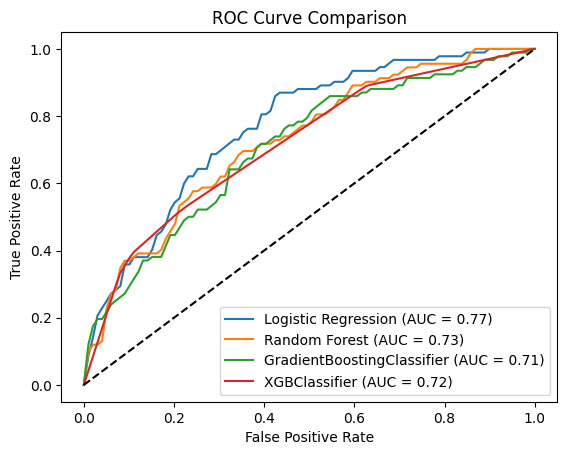

In [21]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, recall_score, accuracy_score, precision_score, f1_score

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=SEED, C=0.581732165256128, penalty='l2', max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=SEED,n_estimators=102,max_depth=14,min_samples_split=13,min_samples_leaf=12,max_features='log2'),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=SEED,n_estimators=296,learning_rate=0.7633726320932392,max_depth=7),
    'XGBClassifier': XGBClassifier(random_state=SEED,n_estimators=215,max_depth=13,learning_rate=0.17807802576685447,min_clild_weight=7,subsample=0.6574435374663536,colsample_bytree=0.5018984738423584,gamma=2.9580696080249433,re_alpha=1.7149483060021373,reg_lambda=6.40550904590499)
}

mean_tprs = {}
mean_fpr = np.linspace(0, 1, 100)

mean_aucs = {}

for name, clf in classifiers.items():  
    features = rfe_features[name]
    X_train_selected = original_X_train[features]
    
    tprs = []
    auc_scores = []
    recall_scores = []
    accuracy_scores = []
    precision_scores = []
    f1_scores = []

    for train_index, valid_index in skf.split(X_train_selected, original_y_train):
        X_train, X_valid = X_train_selected.iloc[train_index], X_train_selected.iloc[valid_index]
        y_train, y_valid = original_y_train.iloc[train_index], original_y_train.iloc[valid_index]
        
        rus = RandomUnderSampler(random_state=SEED)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
        
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = clf.predict_proba(X_valid)[:, 1]
        
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)
        
        recall = recall_score(y_valid, clf.predict(X_valid))
        recall_scores.append(recall)
        
        accuracy = accuracy_score(y_valid, clf.predict(X_valid))
        accuracy_scores.append(accuracy)
        
        precision = precision_score(y_valid, clf.predict(X_valid))
        precision_scores.append(precision)
        
        f1 = f1_score(y_valid, clf.predict(X_valid))
        f1_scores.append(f1)
        
        fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tprs[name] = np.mean(tprs, axis=0)
    mean_aucs[name] = np.mean(auc_scores)
    
    print(f"{name} - Mean AUC: {mean_aucs[name]}, Mean Recall: {np.mean(recall_scores)}, Mean Accuracy: {np.mean(accuracy_scores)}")
    print(f"{name} - Mean Precision: {np.mean(precision_scores)}, Mean F1-score: {np.mean(f1_scores)}")

plt.figure()
for name, mean_tpr in mean_tprs.items():
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_aucs[name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
#plt.savefig('cross-validation.pdf', format='pdf')
plt.show()

### 9. Stacking

#### Takes the output of the validation set as the input to the meta-learner

In [22]:
import warnings
warnings.filterwarnings('ignore')

def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((X_train.shape[0],))
    oof_test = np.zeros((X_test.shape[0],))
    oof_test_skf = np.empty((NFOLDS, X_test.shape[0]))
    
    # Aligned with the index of X_train
    y_train_aligned = y_train.reset_index(drop=True)

    for i, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        X_train_split = X_train.iloc[train_index]
        y_train_split = y_train_aligned.iloc[train_index]
        X_valid = X_train.iloc[valid_index]

        clf.fit(X_train_split, y_train_split)

        oof_train[valid_index] = clf.predict_proba(X_valid)[:, 1]
        oof_test_skf[i, :] = clf.predict_proba(X_test)[:, 1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

#### Defines the meta-learner

In [38]:
lr = LogisticRegression(random_state=SEED, C=0.581732165256128, max_iter=2000)
rf = RandomForestClassifier(random_state=SEED,n_estimators=102,max_depth=14,min_samples_split=13,min_samples_leaf=12,max_features='log2')

In [39]:
lr_features = ['CAT', 'Age', 'EGFR', 'ALB', 'NLR', 'PS', 'CA', 'COPD', 'BE', 'CVD', 'HF', 'PIPD']
rf_features = ['CAT', 'Age', 'Weight', 'EGFR', 'Sex', 'BUN', 'ALB', 'Temp', 'WBC', 'CRP', 'NLR', 'RF', 'PS', 'RH', 'DM', 'CA', 'COPD', 'BE', 'ILD', 'CVD', 'HF', 'OPTH', 'PIPD']

In [40]:
original_X_test = test_df.drop('Result', axis=1)
original_y_test = test_df['Result']

In [41]:
rus = RandomUnderSampler(random_state=SEED)
X_train_resampled, y_train_resampled = rus.fit_resample(original_X_train, original_y_train)
NFOLDS = 3

In [42]:
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['Result'])
y_train_resampled_df

,Result
220,0
672,0
657,0
157,0
720,0
...,...
658,1
29,1
383,1
451,1


In [43]:
lr_oof_train, lr_oof_test = get_oof(lr, X_train_resampled[lr_features], y_train_resampled, original_X_test[lr_features]) 
rf_oof_train, rf_oof_test = get_oof(rf, X_train_resampled[rf_features], y_train_resampled, original_X_test[rf_features])

In [44]:
base_predictions_train = pd.DataFrame( {
    'Logistic Regression': lr_oof_train.ravel(),
    'Random Forest': rf_oof_train.ravel(),
    })
base_predictions_train.head()

,Logistic Regression,Random Forest
0,0.099365,0.309833
1,0.305527,0.419319
2,0.536594,0.524240
3,0.082360,0.360826
4,0.620945,0.584305


In [45]:
X_train_final = np.concatenate((lr_oof_train, rf_oof_train), axis=1)
X_test_final = np.concatenate((lr_oof_test, rf_oof_test), axis=1)

In [46]:
X_train_final_df = pd.DataFrame(X_train_final, index=base_predictions_train.index, columns=base_predictions_train.columns)

In [47]:
X_train_final_df

,Logistic Regression,Random Forest
0,0.099365,0.309833
1,0.305527,0.419319
2,0.536594,0.524240
3,0.082360,0.360826
4,0.620945,0.584305
...,...,...
179,0.384924,0.506111
180,0.616497,0.465367
181,0.896317,0.671339
182,0.709608,0.547970


In [48]:
print(X_train_final.shape, X_test_final.shape)

(184, 2) (150, 2)


#### 10. Hyperparameter Optimization of Stacking

In [52]:
import optuna
from sklearn.model_selection import cross_val_score

def objective_stacking(trial, X_train, y_train):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])

    if penalty in ['l1', 'elasticnet', 'none']:
        solver = 'saga'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    param = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e+6),
        'penalty': penalty,
        'solver': solver,
        'max_iter': 2000,
        'random_state': SEED
    }

    if penalty == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

    clf = LogisticRegression(**param)

    auc = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc').mean()

    return auc


In [53]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_stacking(trial, X_train_final, y_train_resampled), n_trials=400)

print(f"Best Params: {study.best_params}, Best AUC: {study.best_value}")

[I 2024-03-11 14:15:40,787] A new study created in memory with name: no-name-2df0e7f1-f59a-46c0-baeb-d445d59cee38
[I 2024-03-11 14:15:40,798] Trial 0 finished with value: 0.7670250896057347 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.01942957965879111}. Best is trial 0 with value: 0.7670250896057347.
[I 2024-03-11 14:15:40,815] Trial 1 finished with value: 0.7651982888195167 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 20.141710443858912}. Best is trial 0 with value: 0.7670250896057347.
[I 2024-03-11 14:15:40,826] Trial 2 finished with value: 0.7666319805757892 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0004279870300647975}. Best is trial 0 with value: 0.7670250896057347.
[I 2024-03-11 14:15:40,836] Trial 3 finished with value: 0.7633714880332988 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 173.0028273331485}. Best is trial 0 with value: 0.7670250896057347.
[I 2024-03-11 14:15:40,850] Trial 4 finished with value: 0.761614

[I 2024-03-11 14:15:41,369] Trial 40 finished with value: 0.7687940802404901 and parameters: {'penalty': 'elasticnet', 'C': 0.7083472211690435, 'l1_ratio': 0.5148478335133599}. Best is trial 40 with value: 0.7687940802404901.
[I 2024-03-11 14:15:41,385] Trial 41 finished with value: 0.768435657301422 and parameters: {'penalty': 'elasticnet', 'C': 0.5966976996031613, 'l1_ratio': 0.4997946720595516}. Best is trial 40 with value: 0.7687940802404901.
[I 2024-03-11 14:15:41,407] Trial 42 finished with value: 0.7659266967279454 and parameters: {'penalty': 'elasticnet', 'C': 4.779914143873152, 'l1_ratio': 0.5904348237269703}. Best is trial 40 with value: 0.7687940802404901.
[I 2024-03-11 14:15:41,424] Trial 43 finished with value: 0.7673603884842178 and parameters: {'penalty': 'elasticnet', 'C': 0.6635145443121937, 'l1_ratio': 0.298226686957055}. Best is trial 40 with value: 0.7687940802404901.
[I 2024-03-11 14:15:41,441] Trial 44 finished with value: 0.5 and parameters: {'penalty': 'elasticn

[I 2024-03-11 14:15:41,980] Trial 80 finished with value: 0.7651982888195166 and parameters: {'penalty': 'l1', 'C': 3.5191941241373046}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:41,996] Trial 81 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.2231491356830855}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,015] Trial 82 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.3420472544604347}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,030] Trial 83 finished with value: 0.7662851196670135 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 8.331167049594672}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,044] Trial 84 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.0618322713820376}. Best is trial 62 with value:

[I 2024-03-11 14:15:42,579] Trial 120 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.3024709111205653}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,595] Trial 121 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.5013102782740875}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,610] Trial 122 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.1408410066268428}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,626] Trial 123 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.5362956876614161}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:42,640] Trial 124 finished with value: 0.7680656723320615 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 3.060645846739038}. 

[I 2024-03-11 14:15:43,169] Trial 160 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.2735518564825554}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,181] Trial 161 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.01653952578682}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,199] Trial 162 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.1116230906435625}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,214] Trial 163 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.4289426163839258}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,227] Trial 164 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.5374274009456552}. B

[I 2024-03-11 14:15:43,777] Trial 200 finished with value: 0.7687709561799051 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.8340454440532814}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,793] Trial 201 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.0968488363682651}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,807] Trial 202 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.4339762188600993}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,822] Trial 203 finished with value: 0.7680656723320615 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 3.104538874175565}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:43,834] Trial 204 finished with value: 0.7687709561799051 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.8241171381222822}. 

[I 2024-03-11 14:15:44,403] Trial 240 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.0036754731002149}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:44,419] Trial 241 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.126891077483919}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:44,436] Trial 242 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.3698334927455917}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:44,449] Trial 243 finished with value: 0.7687709561799051 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9043530854772376}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:44,465] Trial 244 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.638515846639867}. B

[I 2024-03-11 14:15:45,040] Trial 280 finished with value: 0.7687709561799051 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.7661769925685356}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,056] Trial 281 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.242239425847996}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,070] Trial 282 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.430929268331222}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,086] Trial 283 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.1128574604379045}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,102] Trial 284 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.023585386504619}. Be

[I 2024-03-11 14:15:45,708] Trial 320 finished with value: 0.7616140594288355 and parameters: {'penalty': 'none', 'C': 14.09850193310549}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,728] Trial 321 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.23313278314919664}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,744] Trial 322 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.5657048598355908}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,761] Trial 323 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.1573618667511467}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:45,777] Trial 324 finished with value: 0.7687709561799051 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.8756622224145113}. Best is trial 62 wit

[I 2024-03-11 14:15:46,395] Trial 360 finished with value: 0.7691293791189732 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.265116667182182}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:46,411] Trial 361 finished with value: 0.7684240952711295 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.219383462709108}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:46,429] Trial 362 finished with value: 0.768077234362354 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.21213754211647703}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:46,445] Trial 363 finished with value: 0.7687709561799051 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9081910367326467}. Best is trial 62 with value: 0.7691293791189732.
[I 2024-03-11 14:15:46,461] Trial 364 finished with value: 0.7669904035148573 and parameters: {'penalty': 'l1', 'C': 0.4536003350782261}. Best is trial 62 with va

Best Params: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.4067729897444592}, Best AUC: 0.7691293791189732


In [54]:
best_params = study.best_params

best_params['random_state'] = SEED

best_model_stacking = LogisticRegression(**best_params)

best_model_stacking.fit(X_train_final, y_train_resampled)

LogisticRegression(C=1.4067729897444592, random_state=42, solver='liblinear')

#### 11. SHAP

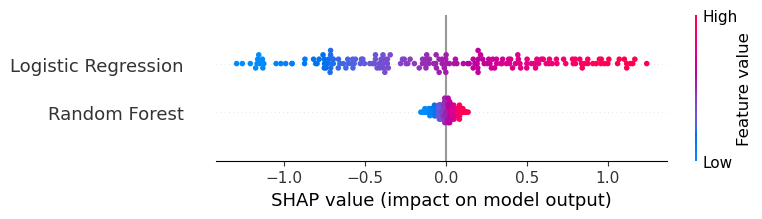

In [37]:
import shap

stacking_feature_names = ['Logistic Regression', 'Random Forest']

explainer = shap.Explainer(best_model_stacking, X_train_final, feature_names=stacking_feature_names)

shap_values = explainer(X_train_final)

shap.summary_plot(shap_values, feature_names=stacking_feature_names)

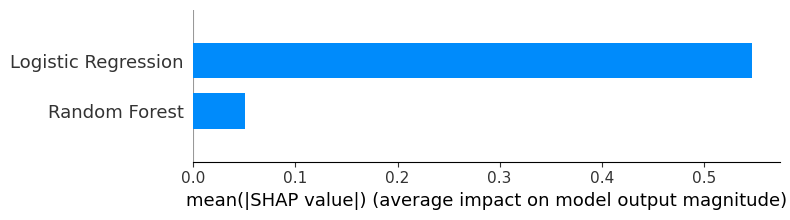

In [42]:
# Create an explainer with the correct feature names
explainer = shap.Explainer(best_model_stacking, X_train_final, feature_names=stacking_feature_names)

# Calculate SHAP values
shap_values = explainer(X_train_final)

# Generate a summary bar plot of SHAP values
shap.summary_plot(shap_values, features=X_train_final, feature_names=stacking_feature_names, plot_type='bar',show=False)
# 指定要保存的PDF文件名
output_pdf_file = "shap_summary_plot.pdf"

# 保存图形为PDF文件
plt.savefig(output_pdf_file, format='pdf', bbox_inches='tight')

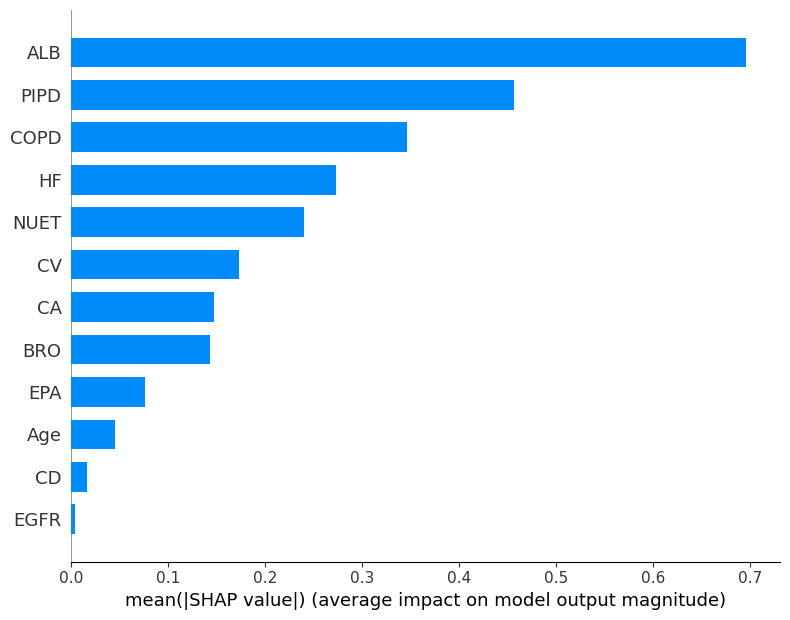

In [46]:
# Analyze the feature importance of the LR model separately
lr.fit(X_train_resampled[lr_features], y_train_resampled)

explainer = shap.Explainer(lr, X_train_resampled[lr_features])

shap_values = explainer.shap_values(X_train_resampled[lr_features])
# Generate a summary bar plot of SHAP values
shap.summary_plot(shap_values, features=X_train_resampled[lr_features], feature_names=lr_features, plot_type='bar',show=False)

# Specify the PDF file name to save
#output_pdf_file = "LR_shap.pdf"

# 保存图形为PDF文件
#plt.savefig(output_pdf_file, format='pdf', bbox_inches='tight')

# 可视化SHAP值，这次应该会显示正确的特征名称
#shap.summary_plot(shap_values, X_train_resampled[lr_features], plot_type='dot')

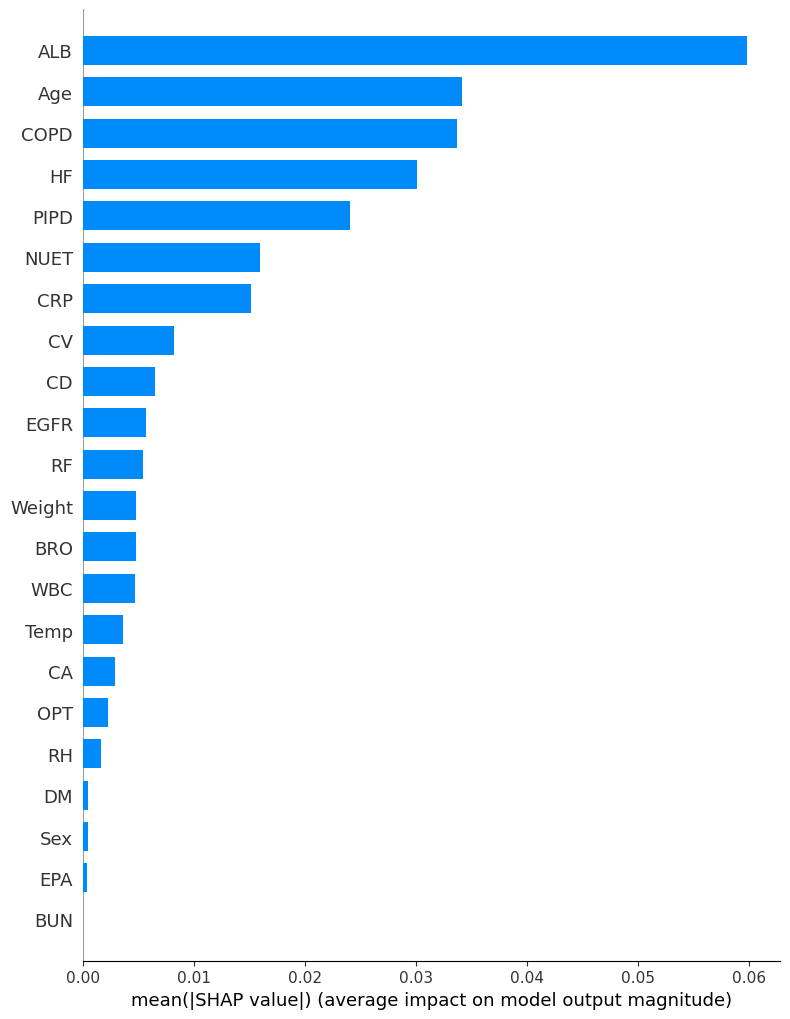

In [47]:
# Analyze the feature importance of the RF model separately
rf.fit(X_train_resampled[rf_features], y_train_resampled)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_resampled[rf_features])
shap.summary_plot(shap_values[1], X_train_resampled[rf_features], plot_type='bar',max_display=22,show=False)


#output_pdf_file = "RF_shap.pdf"
#plt.savefig(output_pdf_file, format='pdf', bbox_inches='tight')

#### 12. Check stacking training effect

Average Accuracy: 0.7125
Average Precision: 0.7199
Average F1-Score: 0.7226
Average ROC AUC: 0.7684
Average Recall: 0.7398


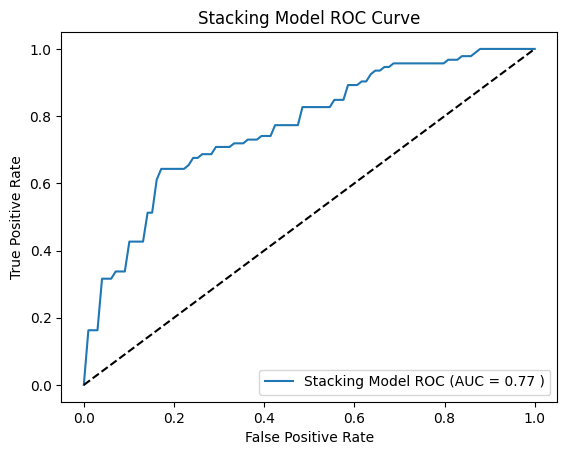

In [50]:
from sklearn.metrics import auc
model_stacking = LogisticRegression(C=1.5571079597270727, random_state=SEED, solver='liblinear')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
acc_scores = []
prec_scores = []
f1_scores = []
recall_scores = []

for train_index, valid_index in skf.split(X_train_final_df, y_train_resampled_df):
    X_train, X_valid = X_train_final_df.iloc[train_index], X_train_final_df.iloc[valid_index]
    y_train, y_valid = y_train_resampled_df.iloc[train_index], y_train_resampled_df.iloc[valid_index]

    model_stacking.fit(X_train, y_train)

    y_pred = model_stacking.predict(X_valid)
    y_pred_proba = model_stacking.predict_proba(X_valid)[:, 1]

    acc_scores.append(accuracy_score(y_valid, y_pred))
    prec_scores.append(precision_score(y_valid, y_pred))
    f1_scores.append(f1_score(y_valid, y_pred))
    recall_scores.append(recall_score(y_valid, y_pred))

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_acc = np.mean(acc_scores)
mean_prec = np.mean(prec_scores)
mean_f1 = np.mean(f1_scores)
mean_recall = np.mean(recall_scores)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

print(f'Average Accuracy: {mean_acc:.4f}')
print(f'Average Precision: {mean_prec:.4f}')
print(f'Average F1-Score: {mean_f1:.4f}')
print(f'Average ROC AUC: {mean_auc:.4f}')
print(f'Average Recall: {mean_recall:.4f}')

plt.plot(mean_fpr, mean_tpr, label=r'Stacking Model ROC (AUC = %0.2f )' % (mean_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Model ROC Curve')
plt.legend(loc='lower right')
#plt.savefig('cross-validation.pdf', format='pdf')
plt.show()

#### 13. stacking Independent test set

Test AUC: 0.6525162615542622, Test Recall: 0.6521739130434783
Test accuracy: 0.6266666666666667
Test precision: 0.23809523809523808
Test f1-score: 0.34883720930232553


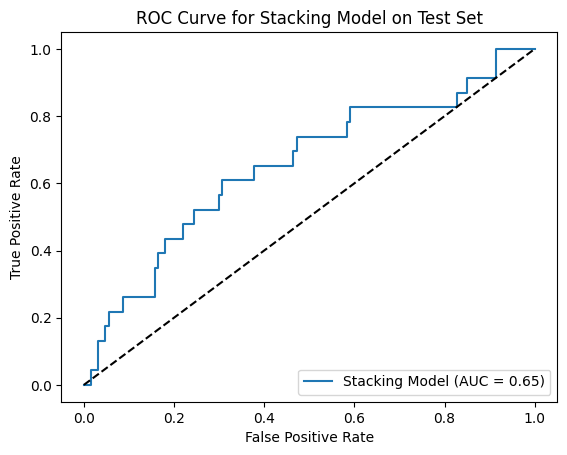

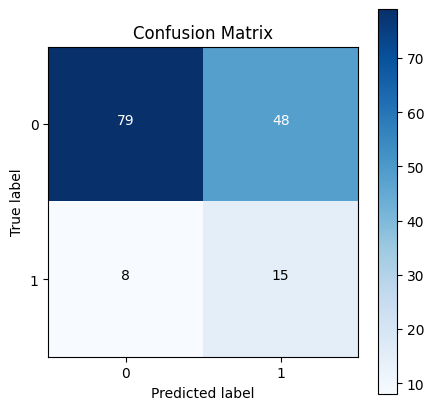

In [55]:
import itertools
from sklearn.metrics import confusion_matrix

y_pred_proba = best_model_stacking.predict_proba(X_test_final)[:, 1]
y_pred = best_model_stacking.predict(X_test_final)

test_auc = roc_auc_score(original_y_test, y_pred_proba)
test_recall = recall_score(original_y_test, y_pred)
test_accuracy = accuracy_score(original_y_test, y_pred)
test_precision = precision_score(original_y_test, y_pred)
test_f1 = f1_score(original_y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(original_y_test, y_pred)

print(f"Test AUC: {test_auc}, Test Recall: {test_recall}")
print(f"Test accuracy: {test_accuracy}")
print(f"Test precision: {test_precision}")
print(f"Test f1-score: {test_f1}")

# plot ROC curve
fpr, tpr, _ = roc_curve(original_y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Stacking Model (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 随机概率线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Model on Test Set')
plt.legend(loc='lower right')
plt.savefig('stacking_test_roc.pdf', format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

# plot confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('stacking test confusion matrix.pdf', format='pdf', bbox_inches='tight')
plt.show()